# EZBattery demo
------------------------------------------
## This demo shows an example for upscaling a lab-scale cell to a 50-cell stack vanadium redox flow battery operating 15 years.
Each stack continuous discharge with three modes:<br>
8h @2.42kW<br>
4h @4.33kW<br>
2.25h @6.25kW<br>
Capacity decay: <0.5% per year<br>
RTE decay : <0.1% per year<br>
RTE at fresh: ~ 75%<br>
limited the SOC 15-85%<br>


## 1. Import all the necessary packages

In [1]:
import os
import sys
import copy
import numpy as np
import pandas as pd
import argparse
import math
import ast
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from scipy import optimize
from matplotlib.ticker import FormatStrFormatter
from EZBattery import BatteryParameter, EZBatteryCell, RFB, searchCurrent, systemPower, LoadExperiment, Calibration, CellLossFunction
from Demo_lib.demo_system import one_year_RPT_run, one_year_run, loss_function_conc, loss_function_mat, callback, differential_evolution_optimize

## 2. Lab-scale cell modeling
#### Load in the cell configuration, properties, and parameters for the lab-scale cell: a 2 x 5 cm vanadium redox flow batter

In [2]:
SDPFPath = 'Data/SDPF_Vanadium_20240718_V5_for_up_scale.xlsx'
PP = BatteryParameter(SDPFPath)


#### Load in the lab-scale experimental data for validating the model.

In [3]:
PP.CalibrationOutputPath = SDPFPath
fname = PP.Experiment.split('\\')[-1]
EXPPath = 'Data' + os.sep + fname
PP.Experiment = EXPPath
F = LoadExperiment(PP)


#### Run the EZBattery model for this lab-scale cell.

In [4]:
Re0=RFB(PP)


#### Plot the figure for comparing the model estiamtion and the experiment data.

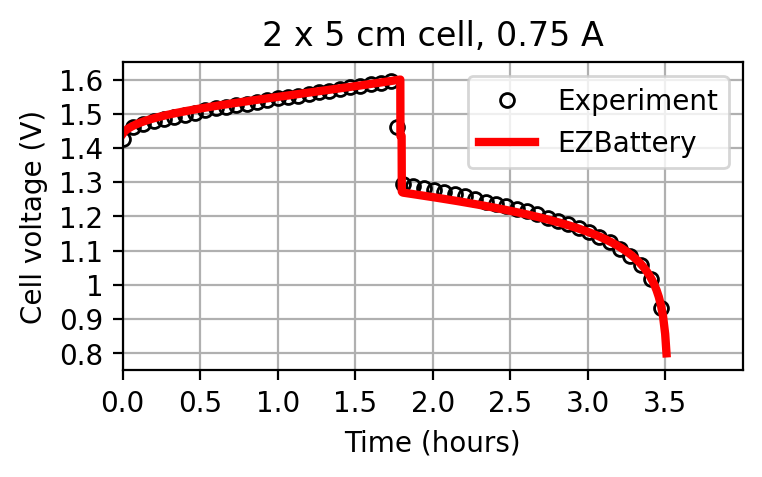

In [5]:
ncx=1
sd=3600
FV = F[F[:,3]<=ncx,:]
plt.figure(figsize=(4,2),dpi=200)
plt.plot(FV[:,0]/sd, FV[:, 1],'o',color='black',mfc='none',markersize=5,markevery=4,label="Experiment",linewidth=2)
plt.plot(Re0['Potentials']['Time_s']/sd,Re0['Potentials']['Ec_V'],'-',color='red',label='EZBattery',markersize=1,linewidth=3)
plt.xlabel('Time (hours)')
plt.ylabel('Cell voltage (V)')
tmax =  int(np.ceil(max(Re0['Potentials']['Time_s'])/sd) + 0)
labels_x = np.arange(0,tmax,0.5)
labels_y = np.arange(0.8,1.7,0.1)
plt.xticks(labels_x, labels_x)
plt.yticks(labels_y, labels_y)
ax = plt.gca()
ax.set_xlim([0,tmax])
ax.set_ylim([0.75,1.65])
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.title('2 x 5 cm cell, 0.75 A')
plt.grid()
plt.legend() 
plt.show()
plt.close()

## 3. Upscaling to 50-cell stack model
#### Load the configurations of the 50-cell stack. Upscaling to 27 x 27 cm cell, consider the shunt current loss, pump loss. 
#### Capacity decay: <0.5% per year
#### RTE decay : <0.1% per year
#### RTE at fresh: ~ 75%
#### limited the SOC 15-85%

In [6]:
SDPFName = 'Data/SDPF_Vanadium_20240718_V5_large_system_v2.xlsx'
SDPFPath = SDPFName
PPstm = BatteryParameter(SDPFPath)


#### Run the EZBattery model for the 50-cell stack for 15 years for the rated power cycling, and save the results in file. The model may need ~8 min to complete.

In [7]:
all_results = []
total_year=15
for nyear in tqdm(range(total_year)):
    results = one_year_RPT_run(nyear,PPstm)
    all_results.append(results)

df = pd.DataFrame(all_results)
df.to_csv('Demo_results/all_years_rate_results.csv', index=False)

  0%|                                                                                                                                                   | 0/15 [00:00<?, ?it/s]

year  0
total charge time : 5.56787109375  (h)
total discharge time : 4.09375  (h)
RTE : 0.7352451109357186  (-)
capacity : 17.7259375  (KWh)


  7%|█████████▎                                                                                                                                 | 1/15 [00:28<06:36, 28.31s/it]

year  1
total charge time : 5.55224609375  (h)
total discharge time : 4.081298828125  (h)
RTE : 0.735071673555536  (-)
capacity : 17.67202392578125  (KWh)


 13%|██████████████████▌                                                                                                                        | 2/15 [01:07<07:30, 34.63s/it]

year  2
total charge time : 5.53662109375  (h)
total discharge time : 4.068115234375  (h)
RTE : 0.7347649704559485  (-)
capacity : 17.61493896484375  (KWh)


 20%|███████████████████████████▊                                                                                                               | 3/15 [01:48<07:29, 37.49s/it]

year  3
total charge time : 5.520751953125  (h)
total discharge time : 4.05078125  (h)
RTE : 0.7337372307964445  (-)
capacity : 17.5398828125  (KWh)


 27%|█████████████████████████████████████                                                                                                      | 4/15 [02:17<06:18, 34.40s/it]

year  4
total charge time : 5.505126953125  (h)
total discharge time : 4.041259765625  (h)
RTE : 0.7340902035566987  (-)
capacity : 17.49865478515625  (KWh)


 33%|██████████████████████████████████████████████▎                                                                                            | 5/15 [02:55<05:55, 35.51s/it]

year  5
total charge time : 5.49072265625  (h)
total discharge time : 4.02734375  (h)
RTE : 0.7334815473543798  (-)
capacity : 17.4383984375  (KWh)


 40%|███████████████████████████████████████████████████████▌                                                                                   | 6/15 [03:31<05:22, 35.82s/it]

year  6
total charge time : 5.475341796875  (h)
total discharge time : 4.014892578125  (h)
RTE : 0.7332679359700361  (-)
capacity : 17.38448486328125  (KWh)


 47%|████████████████████████████████████████████████████████████████▊                                                                          | 7/15 [04:21<05:22, 40.35s/it]

year  7
total charge time : 5.458984375  (h)
total discharge time : 4.001953125  (h)
RTE : 0.7330948121645796  (-)
capacity : 17.32845703125  (KWh)


 53%|██████████████████████████████████████████████████████████████████████████▏                                                                | 8/15 [04:52<04:21, 37.35s/it]

year  8
total charge time : 5.4443359375  (h)
total discharge time : 3.986572265625  (h)
RTE : 0.7322421524663677  (-)
capacity : 17.26185791015625  (KWh)


 60%|███████████████████████████████████████████████████████████████████████████████████▍                                                       | 9/15 [05:31<03:48, 38.04s/it]

year  9
total charge time : 5.428955078125  (h)
total discharge time : 3.9736328125  (h)
RTE : 0.7319332643791878  (-)
capacity : 17.205830078125  (KWh)


 67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 10/15 [06:17<03:21, 40.20s/it]

year  10
total charge time : 5.41015625  (h)
total discharge time : 3.960693359375  (h)
RTE : 0.7320848375451263  (-)
capacity : 17.14980224609375  (KWh)


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 11/15 [07:02<02:47, 41.80s/it]

year  11
total charge time : 5.3984375  (h)
total discharge time : 3.94775390625  (h)
RTE : 0.7312771345875543  (-)
capacity : 17.0937744140625  (KWh)


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 12/15 [07:40<02:02, 40.77s/it]

year  12
total charge time : 5.383056640625  (h)
total discharge time : 3.93463134765625  (h)
RTE : 0.7309288403102181  (-)
capacity : 17.036953735351563  (KWh)


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 13/15 [08:24<01:23, 41.77s/it]

year  13
total charge time : 5.3671875  (h)
total discharge time : 3.90625  (h)
RTE : 0.727802037845706  (-)
capacity : 16.9140625  (KWh)


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 14/15 [08:54<00:38, 38.04s/it]

year  14
total charge time : 5.352783203125  (h)
total discharge time : 3.908935546875  (h)
RTE : 0.7302622576966933  (-)
capacity : 16.92569091796875  (KWh)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [09:39<00:00, 38.65s/it]



#### Load in a pre-run results to visualize the results

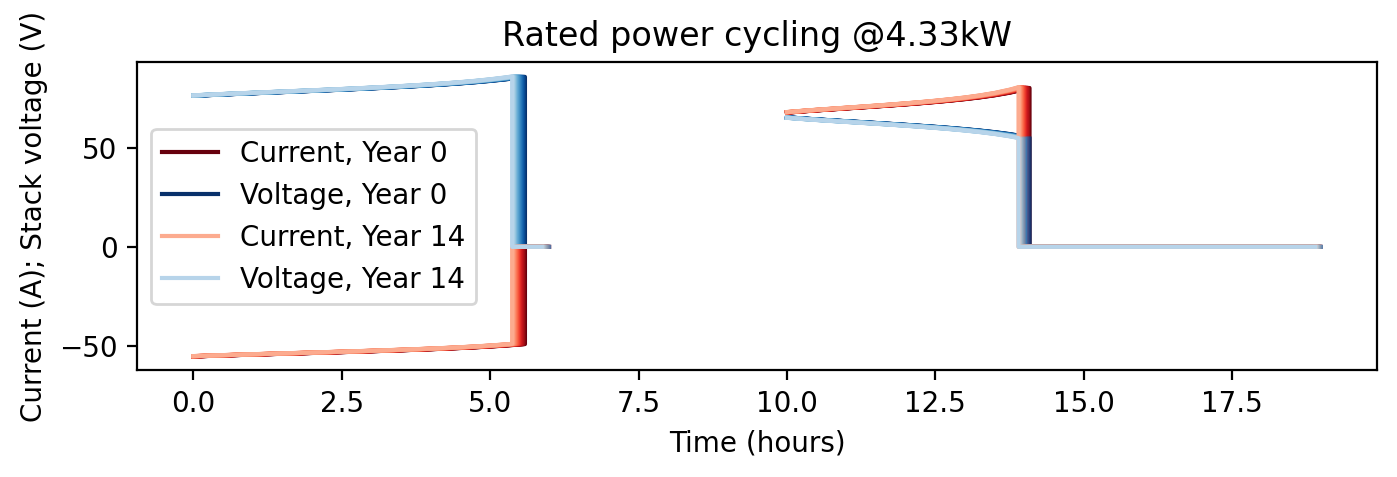

In [8]:
df = pd.read_csv('Demo_results_01/all_years_rate_results.csv')
columns_to_convert = ['syn_socs', 'syn_vs', 'syn_shunts', 'syn_pumps', 'syn_currents', 'syn_hourss', 'syn_act_power']

for column in columns_to_convert:
    df[column] = df[column].apply(ast.literal_eval)
colors = plt.cm.Reds(np.linspace(1, 0.3, 15))
colors2 = plt.cm.Blues(np.linspace(1, 0.3, 15))
plt.figure(figsize=(8,2),dpi=200)
for nyear in range(15):
    df_year_1 = df[df['year'] == nyear]
    syn_hourss_year_1 = np.asarray(df_year_1['syn_hourss'].values[0]) # Use .values[0] to get the list
    syn_currents_year_1 = np.asarray(df_year_1['syn_currents'].values[0])  # Use .values[0] to get the list
    syn_vs_year_1 = np.asarray(df_year_1['syn_vs'].values[0]) # Use .values[0] to get the list
    syn_socs_1 = np.asarray(df_year_1['syn_socs'].values[0])
    syn_act_power_1 = np.asarray(df_year_1['syn_act_power'].values[0])
    syn_socs_1=np.copy(syn_socs_1[:-1])
    syn_hourss_year_plot=syn_hourss_year_1[:-1]
    charge_socs = syn_socs_1[syn_hourss_year_plot <= 6]
    discharge_socs = syn_socs_1[syn_hourss_year_plot >= 10]
    charge_currents = syn_currents_year_1[syn_hourss_year_plot <= 6]
    discharge_currents = syn_currents_year_1[syn_hourss_year_plot >= 10]
    charge_volts = syn_vs_year_1[syn_hourss_year_plot <= 6]
    discharge_volts = syn_vs_year_1[syn_hourss_year_plot >= 10]
    charge_hours=syn_hourss_year_plot[syn_hourss_year_plot <= 6]
    discharge_hours=syn_hourss_year_plot[syn_hourss_year_plot >= 10]
    if nyear==0 or nyear==14:
        plt.plot(charge_hours, charge_currents, '-',color=colors[nyear], label=f'Current, Year {nyear}',mfc='none',markersize=5,markevery=1)
        plt.plot(charge_hours, charge_volts*50, '-',color=colors2[nyear], label=f'Voltage, Year {nyear}',mfc='none',markersize=5,markevery=1)
    else:
        plt.plot(charge_hours, charge_currents, '-',color=colors[nyear],mfc='none',markersize=5,markevery=1)
        plt.plot(charge_hours, charge_volts*50, '-',color=colors2[nyear],mfc='none',markersize=5,markevery=1)
    plt.plot(discharge_hours, discharge_currents, '-',color=colors[nyear],mfc='none',markersize=5,markevery=1)
    plt.plot(discharge_hours, discharge_volts*50, '-',color=colors2[nyear],mfc='none',markersize=5,markevery=1)
plt.xlabel('Time (hours)')
plt.ylabel('Current (A); Stack voltage (V)')
plt.title('Rated power cycling @4.33kW')
plt.legend(loc='best')
plt.show()

## 4. Operating the 50-cell stack with duty cycles
#### Synthetic duty cycles data for 15 years, 2025/01/01 - 2039/12/31.
#### The system can operate 0-3 cycles per day.
#### Higher chance charging during night, and higher chance discharging during daytime.
#### Summer and Winter have more cycles per day, spring and fall have fewer cycles per day.
#### Set 2027, 2033, 2035 have more cycles.

In [9]:
data = pd.read_csv("Data/synthetic_battery_data_15_years.csv", index_col=0, parse_dates=True)
nyear=2030
data_time_power = data[(data.index.year == nyear)]
data_power=data_time_power['Power (kW)'].to_numpy()
data_time=data_time_power.index.to_numpy()


#### Plot the stack power load in the picked year

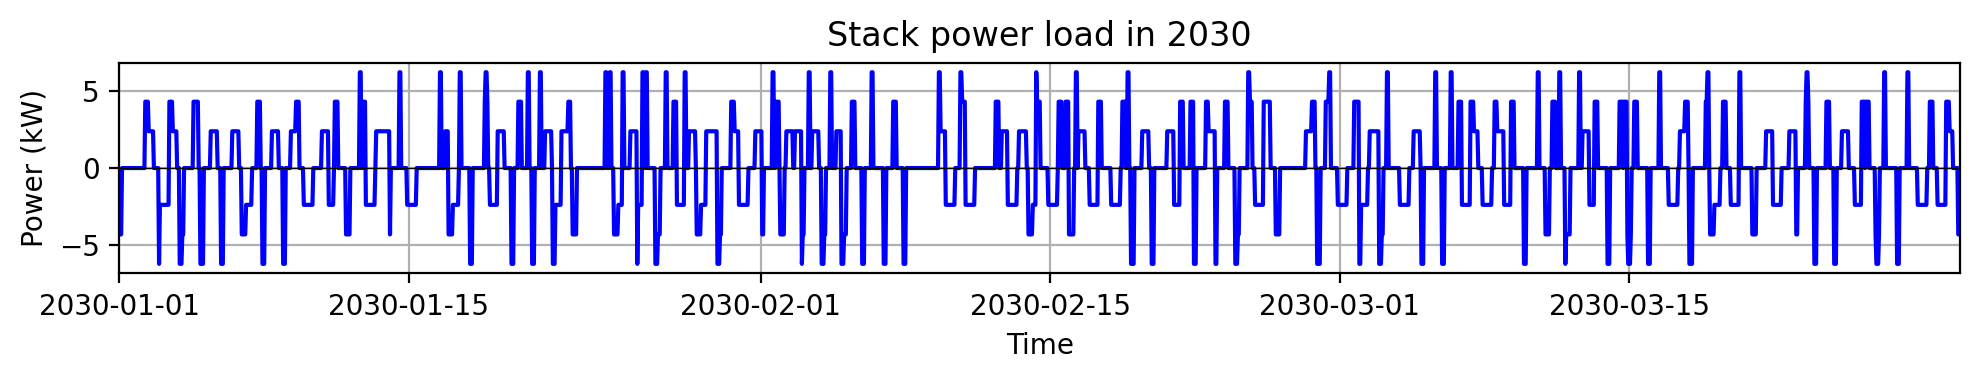

In [10]:
start_date = pd.Timestamp("2030-01-01")
end_date = pd.Timestamp("2030-03-31")
plt.figure(figsize=(10, 2),dpi=200)
plt.plot(data_time, data_power, label="Power (kW)", color='b')
plt.axhline(0, color='black', lw=0.5)
plt.title("Stack power load in "+str(nyear))
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.xlim(start_date, end_date)
plt.grid(True)
plt.tight_layout()
plt.show()


### Load in the same 50-cell stack configuration file. Run EZBattery model. This may take a few hours to complete.

In [11]:
SDPFName = 'Data/SDPF_Vanadium_20240718_V5_large_system_v2.xlsx'
SDPFPath = SDPFName
PPstm = BatteryParameter(SDPFPath)
start_time=data_time[0]
results_file_base='Demo_results/syn_data'
results = one_year_run(nyear,PPstm,data_time_power,start_time,results_file_base)

2030-01-01 08:00:00 ,    Hours 8.000     , Cycles 0    ,  Power 0.000     (W), SOC 0.85000   , dt 0.250 (hrs)
2030-01-01 16:00:00 ,    Hours 16.000    , Cycles 0    ,  Power 0.000     (W), SOC 0.85000   , dt 0.250 (hrs)
2030-01-02 00:00:00 ,    Hours 24.000    , Cycles 0    ,  Power 0.000     (W), SOC 0.85000   , dt 0.250 (hrs)
2030-01-02 08:00:00 ,    Hours 32.000    , Cycles 0    ,  Power 4330.000  (W), SOC 0.51452   , dt 0.250 (hrs)
2030-01-03 00:00:00 ,    Hours 48.000    , Cycles 1    ,  Power -2400.000 (W), SOC 0.41055   , dt 0.250 (hrs)
2030-01-04 00:00:00 ,    Hours 72.000    , Cycles 2    ,  Power -6250.000 (W), SOC 0.52095   , dt 0.250 (hrs)
2030-01-04 16:00:00 ,    Hours 88.000    , Cycles 2    ,  Power 4330.000  (W), SOC 0.51453   , dt 0.250 (hrs)
2030-01-05 00:00:00 ,    Hours 96.000    , Cycles 3    ,  Power -6250.000 (W), SOC 0.52095   , dt 0.250 (hrs)
2030-01-05 16:00:00 ,    Hours 112.000   , Cycles 3    ,  Power 2400.000  (W), SOC 0.29459   , dt 0.250 (hrs)
2030-01-06

AttributeError: 'list' object has no attribute 'tolist'


### For demonstration, we directly load in a pre-run results for 15 years operation from previous run.

In [12]:
directory = 'Demo_results_01'
file_pattern = 'syn_data_year_20{}.csv'
years = range(25, 39)
column_names = ['datetime', 'column_2', 'ncyc', 'power', 'column_4', 'column_5', 'current', 'cell_v', 'socs']
all_weekly_charge = pd.DataFrame()
all_weekly_discharge = pd.DataFrame()

for year in years:
    file_path = os.path.join(directory, file_pattern.format(year))    
    if os.path.exists(file_path):
        data = pd.read_csv(file_path, header=None, names=column_names, parse_dates=[0], dayfirst=True)
        data['datetime'] = data['datetime'].str.strip()
        data['datetime'] = data['datetime'].apply(lambda x: ' '.join(x.split('.')[:-1]) if '.' in x else x)
        data['datetime'] = pd.to_datetime(data['datetime']).dt.round('s')
        data.set_index('datetime', inplace=True)
        data['time_diff'] = data.index.to_series().diff().dt.total_seconds().div(3600)
        data['energy'] = data['power'] * data['time_diff'] / 1000
        data_charge = data[data['power']<0]
        data_discharge = data[data['power']>0]
        weekly_charge = data_charge.resample('W').sum()
        weekly_discharge = data_discharge.resample('W').sum()
        all_weekly_charge = pd.concat([all_weekly_charge, weekly_charge])
        all_weekly_discharge = pd.concat([all_weekly_discharge, weekly_discharge])
    else:
        print(f"File not found: {file_path}")
all_weekly_charge.sort_index(inplace=True)
all_weekly_discharge.sort_index(inplace=True)


### Visualize a summary of the results: weekly energy inputs and outputs for the stack.

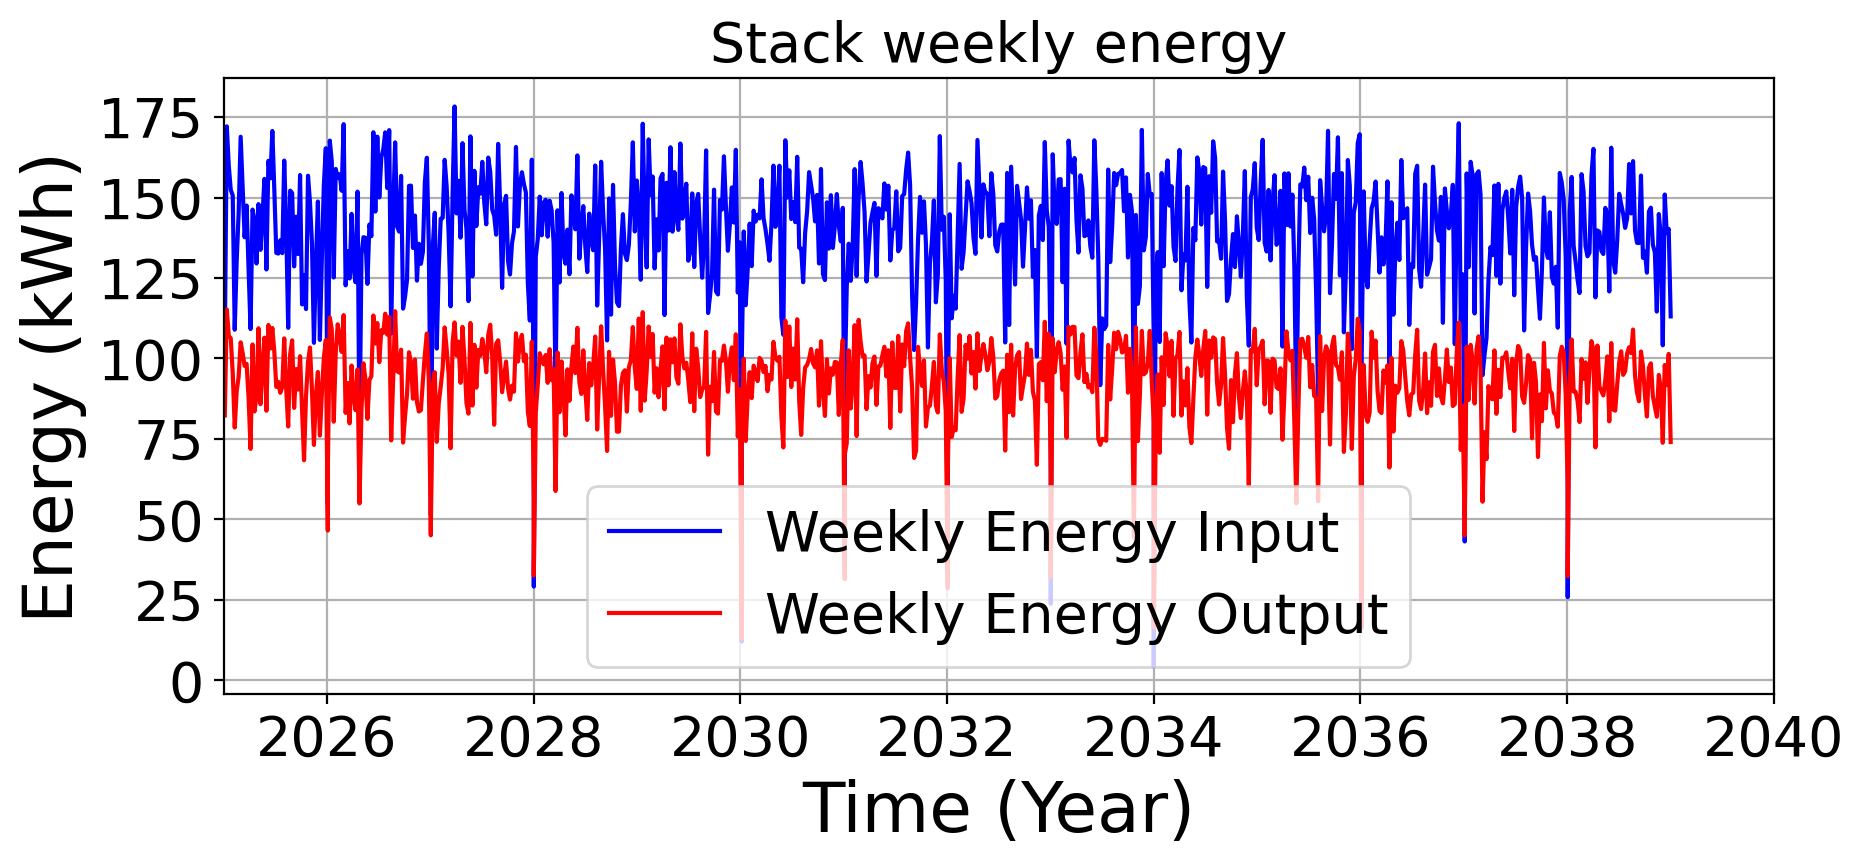

In [13]:
start_date = pd.Timestamp("2025-01-01")
end_date = pd.Timestamp("2040-01-01")
plt.figure(figsize=(10, 4),dpi=200)
plt.plot(all_weekly_charge.index, -all_weekly_charge['energy'], label='Weekly Energy Input', color='blue')
plt.plot(all_weekly_discharge.index, all_weekly_discharge['energy'], label='Weekly Energy Output', color='red')
plt.xlabel('Time (Year)', fontsize=25)
plt.ylabel('Energy (kWh)', fontsize=25)
plt.title('Stack weekly energy', fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(start_date, end_date)
plt.grid(True)
plt.show()


### Visualize the detailed stack performance in the picked time period.

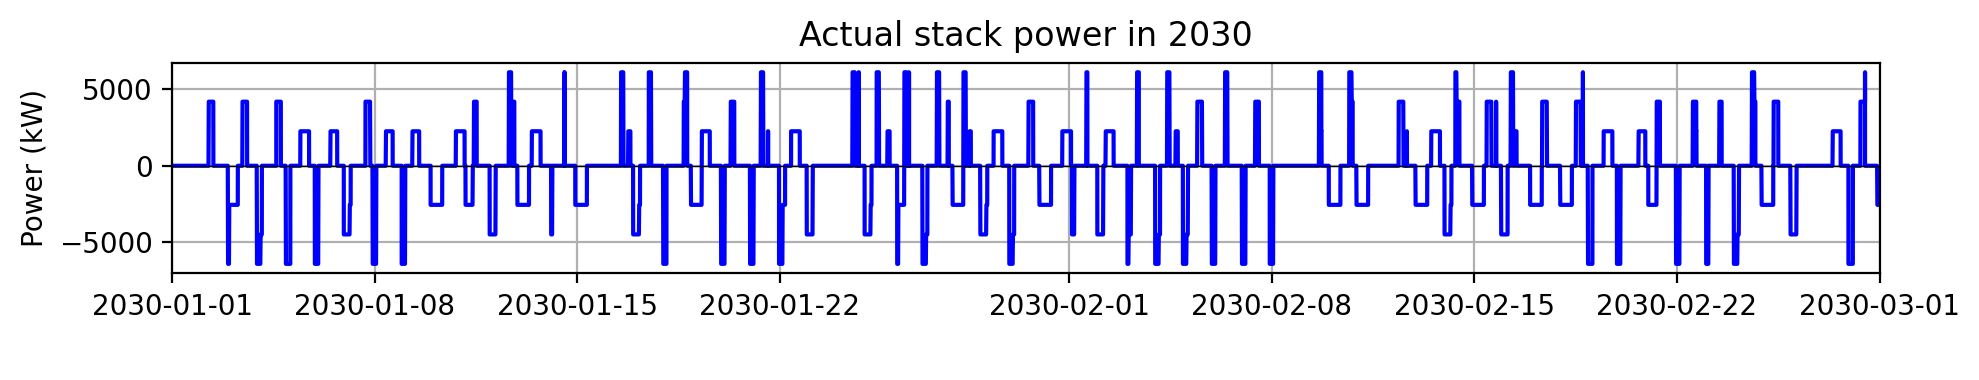

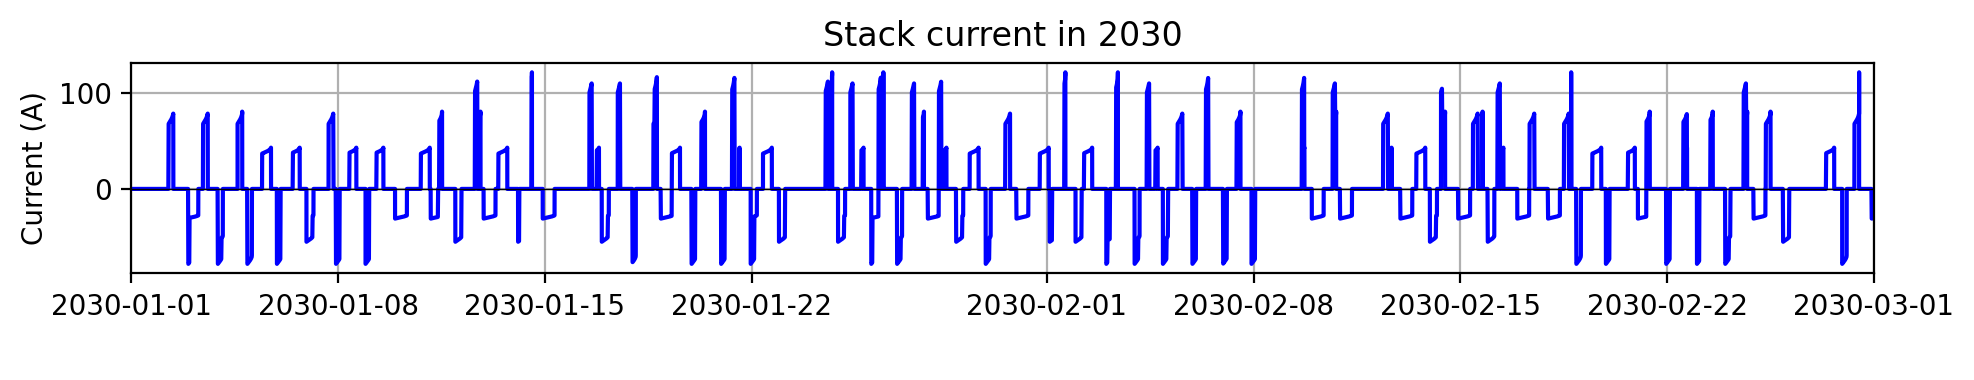

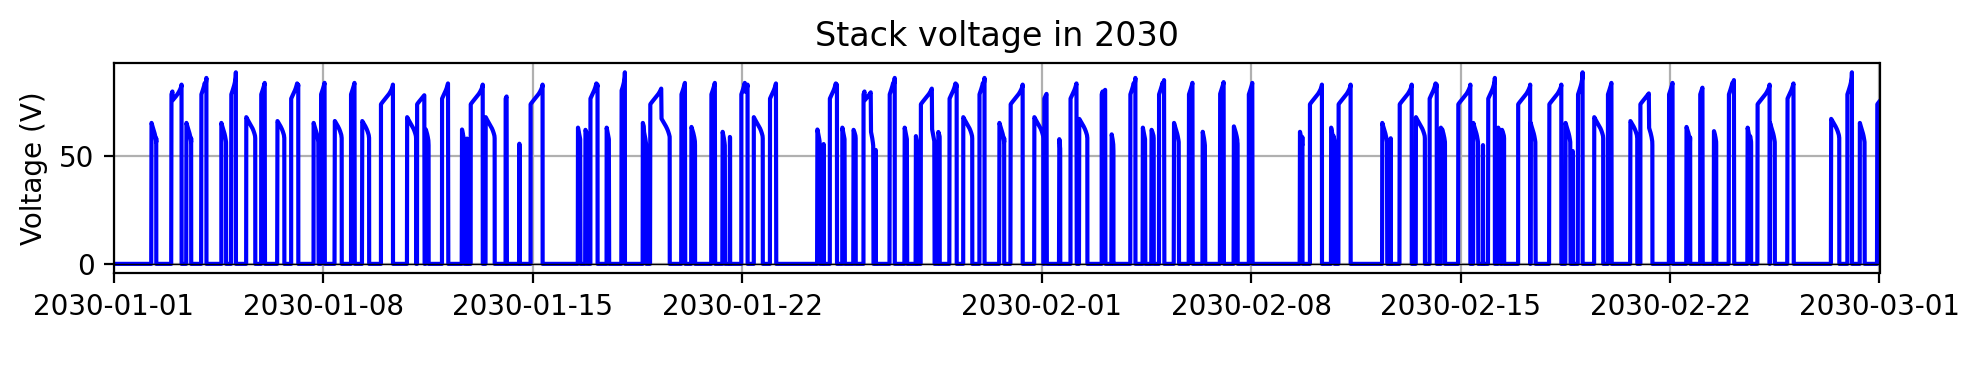

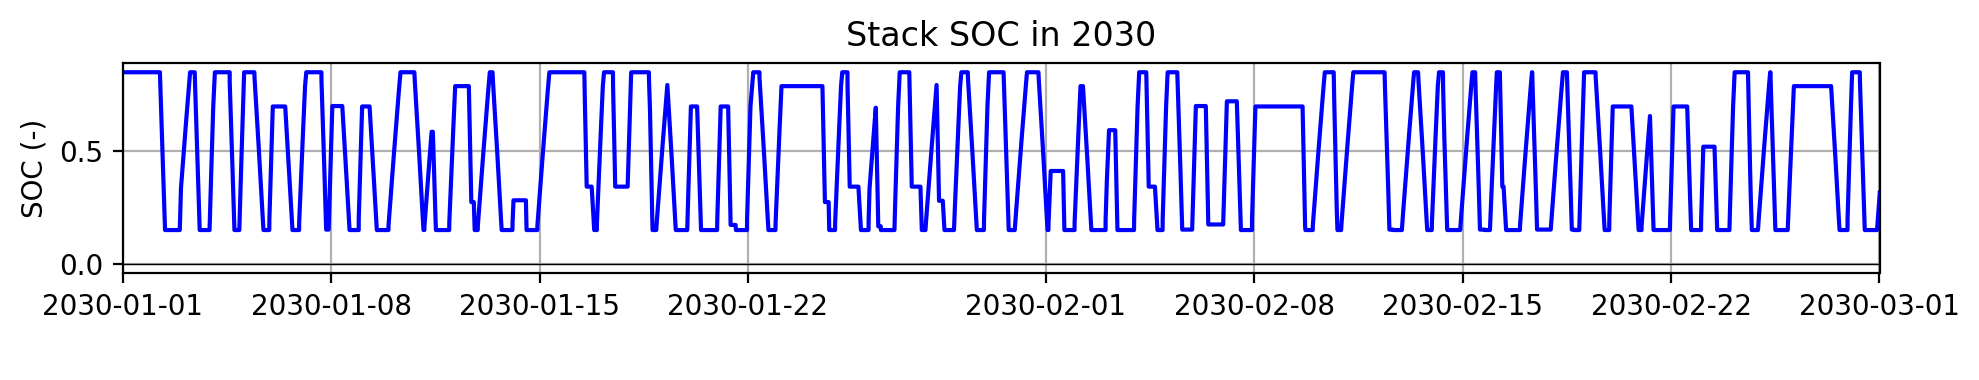

In [14]:
SDPFName = 'Data/SDPF_Vanadium_20240718_V5_large_system_v2.xlsx'
SDPFPath = SDPFName
PPstm = BatteryParameter(SDPFPath)
nyear=2030
file_path = os.path.join(directory, file_pattern.format(nyear-2000))
data = pd.read_csv(file_path, header=None, names=column_names, parse_dates=[0], dayfirst=True)
data_power=data['power'] #.to_numpy()
data_current=data['current']
data_v=data['cell_v']
data_soc=data['socs']
data['datetime'] = data['datetime'].str.strip()
data['datetime'] = data['datetime'].apply(lambda x: ' '.join(x.split('.')[:-1]) if '.' in x else x)
data['datetime'] = pd.to_datetime(data['datetime']).dt.round('s')
data_time=data['datetime'].to_numpy()

start_date = pd.Timestamp("2030-01-01")
end_date = pd.Timestamp("2030-03-01")

plt.figure(figsize=(10, 2),dpi=200)
plt.plot(data_time, data_power, label="Power (kW)", color='b')
plt.axhline(0, color='black', lw=0.5)
plt.title("Actual stack power in "+str(nyear))
plt.xlabel(" ")
plt.ylabel("Power (kW)")
plt.xlim(start_date, end_date)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 2),dpi=200)
plt.plot(data_time, data_current, label="Current", color='b')
plt.axhline(0, color='black', lw=0.5)
plt.title("Stack current in "+str(nyear))
plt.xlabel(" ")
plt.ylabel("Current (A)")
plt.xlim(start_date, end_date)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 2),dpi=200)
plt.plot(data_time, data_v*PPstm.CellNumber, label="Voltage", color='b')
plt.axhline(0, color='black', lw=0.5)
plt.title("Stack voltage in "+str(nyear))
plt.xlabel(" ")
plt.ylabel("Voltage (V)")
plt.xlim(start_date, end_date)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 2),dpi=200)
plt.plot(data_time, data_soc, label="SOC", color='b')
plt.axhline(0, color='black', lw=0.5)
plt.title("Stack SOC in "+str(nyear))
plt.xlabel(" ")
plt.ylabel("SOC (-)")
plt.xlim(start_date, end_date)
plt.grid(True)
plt.tight_layout()
plt.show()

## 5.Diagnosis
#### Load in the synthetic stack data as the demo for diagnosis. It can be the real streaming stack data.
#### Analyze the data to diagnose the stack/cell properties' decay.

Diagnose  Demo_results_01//syn_data_year_2030.csv   month 1


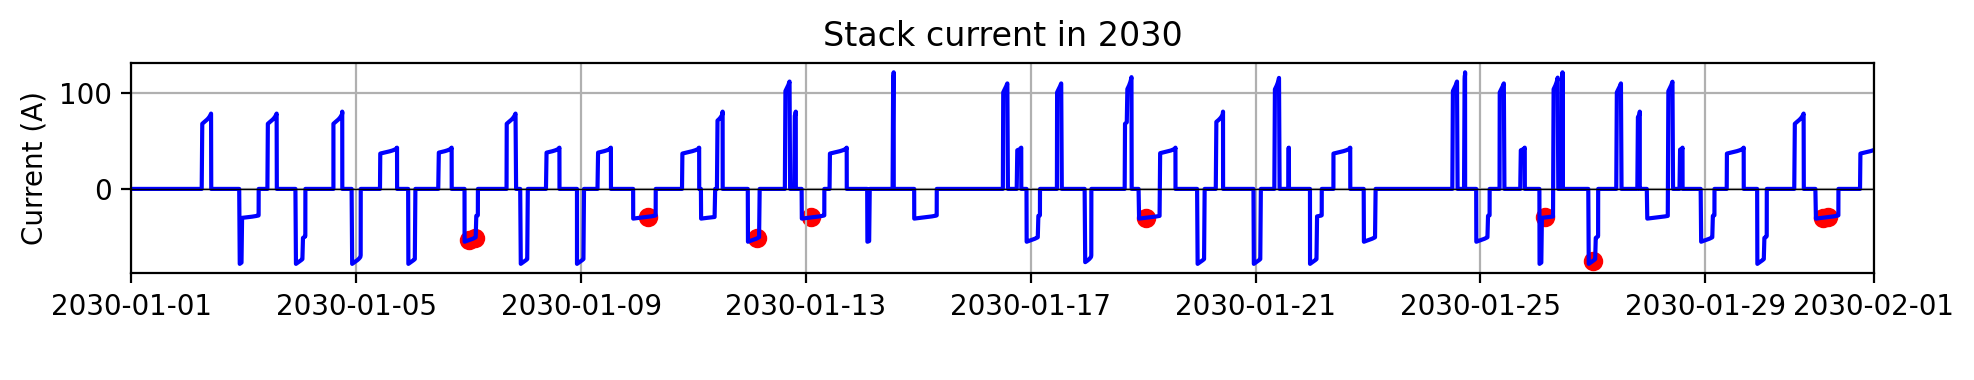

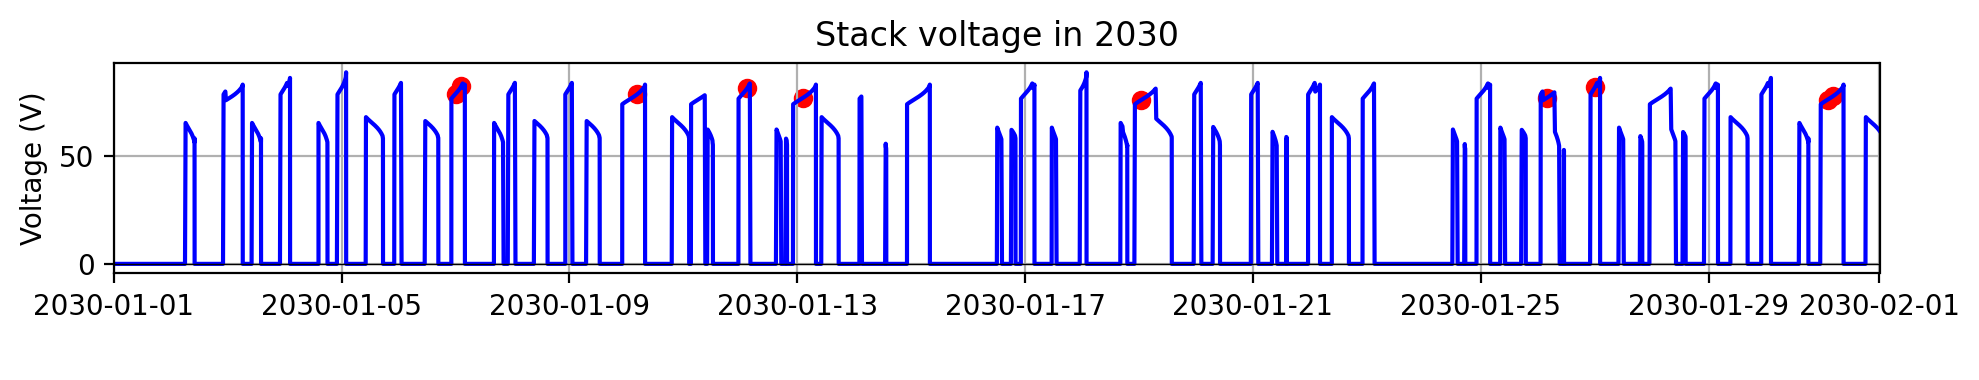

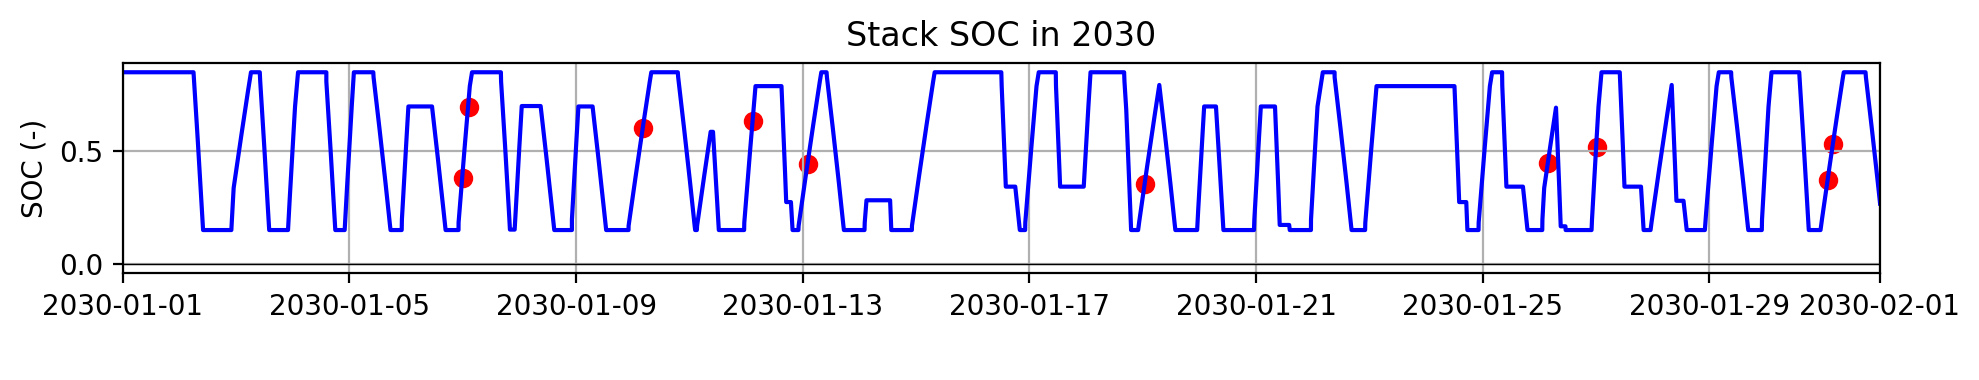

In [15]:
nyear=2030
stream_data_folder = 'Demo_results_01'
stream_data_file=stream_data_folder+'//syn_data_year_'+str(nyear)+'.csv'
df = pd.read_csv(stream_data_file,header=None)
df.columns = ['Date_time', 'Hours', 'NumCyc', 'Power(W)', 'Shunt(W)', 'Pump(W)', 'Current(A)', 'Voltage(V)', 'SOC']
df['SOC'] = df['SOC'].shift(1)
df['Hours'] = df['Hours'].shift(1)

df = df.drop(index=0).reset_index(drop=True)
df['SOC_diff'] = df['SOC'].diff()
df['Hours_diff'] = df['Hours'].diff()
df['SOC_diff'] = df['SOC_diff'].fillna(0)
df['Hours_diff'] = df['Hours_diff'].fillna(0)
df['Date_time'] = pd.to_datetime(df['Date_time'], format='mixed')
pick_month=1
df_1m = df[df['Date_time'].dt.month == pick_month]
print('Diagnose ',stream_data_file,'  month',pick_month,flush=True)
df_1m_non_zero_current = df_1m[(df_1m['Current(A)'] != 0) & (df_1m['SOC'] >= 0.3) & (df_1m['SOC'] <= 0.7) &(df_1m['Hours_diff']>=0.25) & (df_1m['SOC_diff']>=0.01)]
selected_rows = df_1m_non_zero_current.sample(n=10)

true_time = selected_rows['Date_time'].tolist()
true_socs = selected_rows['SOC'].tolist()
true_currents = selected_rows['Current(A)'].tolist()
true_volts = selected_rows['Voltage(V)'].tolist()
true_soc_diff = selected_rows['SOC_diff'].tolist()
true_hours_diff = selected_rows['Hours_diff'].tolist()

start_date = pd.Timestamp("2030-01-01")
end_date = pd.Timestamp("2030-02-01")

plt.figure(figsize=(10, 2),dpi=200)
plt.plot(data_time, data_current, label="Current", color='b')
plt.scatter(true_time,true_currents,color='red')
plt.axhline(0, color='black', lw=0.5)
plt.title("Stack current in "+str(nyear))
plt.xlabel(" ")
plt.ylabel("Current (A)")
plt.xlim(start_date, end_date)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 2),dpi=200)
plt.plot(data_time, data_v*PPstm.CellNumber, label="Voltage", color='b')
plt.scatter(true_time,np.asarray(true_volts)*PPstm.CellNumber,color='red')
plt.axhline(0, color='black', lw=0.5)
plt.title("Stack voltage in "+str(nyear))
plt.xlabel(" ")
plt.ylabel("Voltage (V)")
plt.xlim(start_date, end_date)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 2),dpi=200)
plt.plot(data_time, data_soc, label="SOC", color='b')
plt.scatter(true_time,true_socs,color='red')
plt.axhline(0, color='black', lw=0.5)
plt.title("Stack SOC in "+str(nyear))
plt.xlabel(" ")
plt.ylabel("SOC (-)")
plt.xlim(start_date, end_date)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Apply Differential Evolution approach to explore the cell property and parameter space to make the EZBattery estimations to match the load in data.
#### Use 2030/01 as example

In [16]:
SDPFName = 'Data/SDPF_Vanadium_20240718_V5_large_system_v2.xlsx'
SDPFPath = SDPFName
PPstm = BatteryParameter(SDPFPath)
#pick the year and month
nyear=2030
pick_month=1

stream_data_folder = 'Demo_results_01'
stream_data_file=stream_data_folder+'//syn_data_year_'+str(nyear)+'.csv'
df = pd.read_csv(stream_data_file,header=None)
df.columns = ['Date_time', 'Hours', 'NumCyc', 'Power(W)', 'Shunt(W)', 'Pump(W)', 'Current(A)', 'Voltage(V)', 'SOC']
df['SOC'] = df['SOC'].shift(1)
df['Hours'] = df['Hours'].shift(1)
df = df.drop(index=0).reset_index(drop=True)
df['SOC_diff'] = df['SOC'].diff()
df['Hours_diff'] = df['Hours'].diff()
df['SOC_diff'] = df['SOC_diff'].fillna(0)
df['Hours_diff'] = df['Hours_diff'].fillna(0)
df['Date_time'] = pd.to_datetime(df['Date_time'], format='mixed')
df_1m = df[df['Date_time'].dt.month == pick_month]
df_1m_non_zero_current = df_1m[(df_1m['Current(A)'] != 0) & (df_1m['SOC'] >= 0.3) & (df_1m['SOC'] <= 0.7) &(df_1m['Hours_diff']>=0.25) & (df_1m['SOC_diff']>=0.01)]
final_loss=1
while final_loss>0.001:
    selected_rows = df_1m_non_zero_current.sample(n=10)
    true_time = selected_rows['Date_time'].tolist()
    true_socs = selected_rows['SOC'].tolist()
    true_currents = selected_rows['Current(A)'].tolist()
    true_volts = selected_rows['Voltage(V)'].tolist()
    true_soc_diff = selected_rows['SOC_diff'].tolist()
    true_hours_diff = selected_rows['Hours_diff'].tolist()
    bounds=[(0.85,1.00)]
    result = differential_evolution_optimize(loss_function_conc, bounds, (PPstm, true_socs, true_currents,true_volts,true_soc_diff,true_hours_diff))
    final_loss=result.fun
result2 = differential_evolution_optimize(loss_function_mat, bounds, (PPstm, true_socs, true_currents,true_volts,true_soc_diff,true_hours_diff,result['x'][0]))
print('Year',nyear,'Month',pick_month, '  Normalized balanced active speices:', result['x'][0],'  Normalized membrane conductivity and reaction rate constants:',result2['x'][0],flush=True)


differential_evolution step 1: f(x)= 4.91254e-05
Current best solution: [0.97956659], Convergence: 0.012874490300971202
differential_evolution step 2: f(x)= 4.91254e-05
Current best solution: [0.97956659], Convergence: 0.01794840794197006
differential_evolution step 3: f(x)= 3.58571e-05
Current best solution: [0.98113345], Convergence: 0.01764019343742487
differential_evolution step 4: f(x)= 3.58571e-05
Current best solution: [0.98113345], Convergence: 0.020138478736684208
differential_evolution step 5: f(x)= 3.52022e-05
Current best solution: [0.98098884], Convergence: 0.028650778006121286
differential_evolution step 6: f(x)= 3.49819e-05
Current best solution: [0.98081371], Convergence: 0.07494385924317916
differential_evolution step 7: f(x)= 3.49819e-05
Current best solution: [0.98081371], Convergence: 0.07771105808044712
differential_evolution step 8: f(x)= 3.49749e-05
Current best solution: [0.98083286], Convergence: 1.3189705594638599
Polishing solution with 'L-BFGS-B'
differentia

#### Load in a pre-run diagnosis results for visualization.

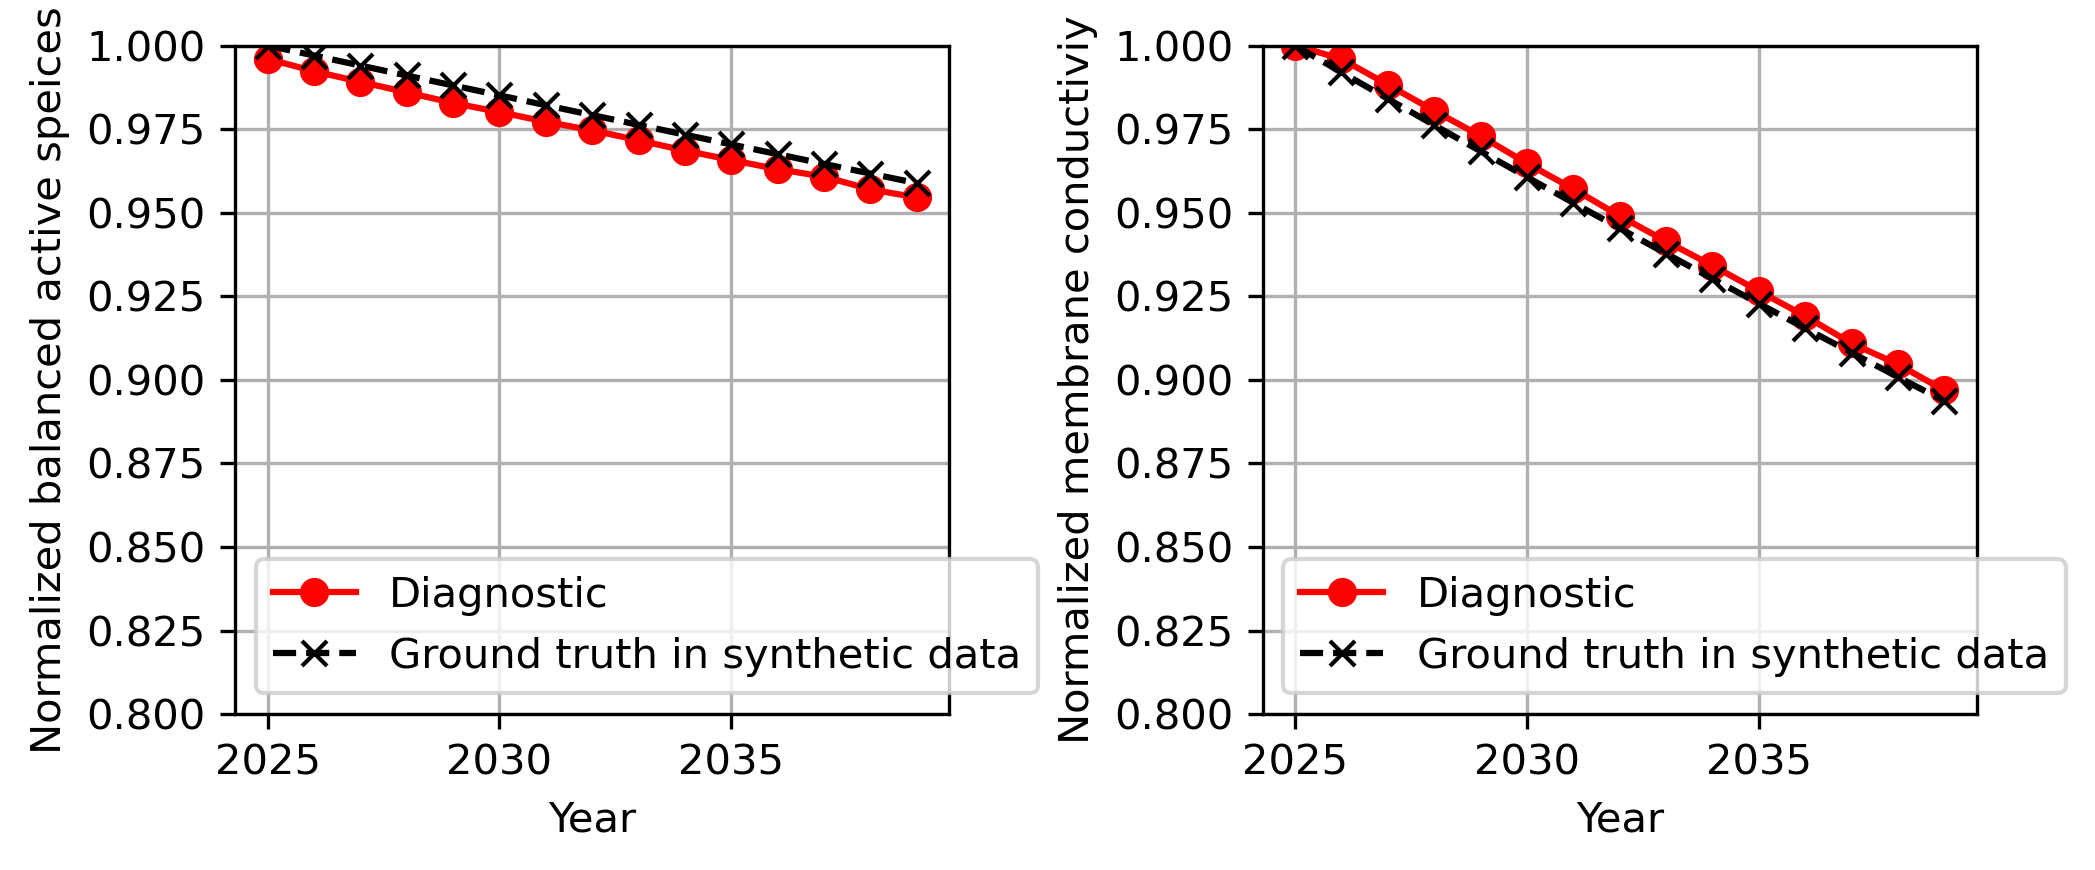

In [17]:
file_path = 'Demo_results_01\synthetic_system_diagnosis_results.csv'
years = []
results_x1 = []
results_x2 = []
with open(file_path, 'r') as file:
    for line in file:
        match = re.match(r'year (\d{4}) month \d+   results x: ([0-9.]+) ([0-9.]+)', line)
        if match:
            years.append(int(match.group(1)))
            results_x1.append(float(match.group(2)))
            results_x2.append(float(match.group(3)))
data = pd.DataFrame({
    'year': years,
    'results_x1': results_x1,
    'results_x2': results_x2
})
reference_x1 = [1 * (0.997 ** (year - years[0])) for year in years]
reference_x2 = [1 * (0.992 ** (year - years[0])) for year in years]

fig, axs = plt.subplots(1, 2, figsize=(7, 3),dpi=300)
axs[0].plot(data['year'], data['results_x1'], marker='o', label='Diagnostic',color='red')
axs[0].plot(data['year'], reference_x1, marker='x', linestyle='--', label='Ground truth in synthetic data',color='black')
#axs[0].set_title('Results X1 over the years')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Normalized balanced active speices')
axs[0].legend()
axs[0].set_ylim(0.8, 1)
axs[0].grid(True)
axs[1].plot(data['year'], data['results_x2'], marker='o', label='Diagnostic',color='red')
axs[1].plot(data['year'], reference_x2, marker='x', linestyle='--', label='Ground truth in synthetic data',color='black')
#axs[1].set_title('Results X2 over the years')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Normalized membrane conductiviy')
axs[1].legend()
axs[1].set_ylim(0.8, 1)
axs[1].grid(True)
plt.tight_layout()
plt.show()